In [1]:
from IPython.core.display import display, HTML # for some notebook formatting.

import mlrose_hiive
import numpy as np
import logging
import networkx as nx
import matplotlib.pyplot as plt
import string
from sklearn.metrics import *
from sklearn.metrics import roc_auc_score
import sklearn

from ast import literal_eval
import chess

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score
from mlrose_hiive import QueensGenerator, MaxKColorGenerator, TSPGenerator
from mlrose_hiive import RHCRunner, SARunner, GARunner, MIMICRunner, NNGSRunner

In [2]:
bc=pd.read_csv('Breast_cancer_data.csv')
#https://www.kaggle.com/merishnasuwal/breast-cancer-prediction-dataset
bc=bc[bc.isnull().any(axis=1)==False]

In [3]:
X = bc.loc[:, bc.columns != 'diagnosis']
y = bc.loc[:, bc.columns == 'diagnosis']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, shuffle=True, stratify=y)

In [5]:
X_train

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness
405,10.94,18.59,70.39,370.0,0.10040
568,7.76,24.54,47.92,181.0,0.05263
99,14.42,19.77,94.48,642.5,0.09752
263,15.61,19.38,100.00,758.6,0.07840
420,11.57,19.04,74.20,409.7,0.08546
...,...,...,...,...,...
276,11.33,14.16,71.79,396.6,0.09379
429,12.72,17.67,80.98,501.3,0.07896
15,14.54,27.54,96.73,658.8,0.11390
497,12.47,17.31,80.45,480.1,0.08928


In [6]:
def show_performance_metrics(y_pred, y_test, y_prob):
    accuracy = accuracy_score(y_pred, y_test)
    precision = precision_score(y_pred, y_test)
    recall = recall_score(y_pred, y_test)
    f1score = f1_score(y_pred, y_test)
    roc_auc_score=sklearn.metrics.roc_auc_score(y_test, y_prob)
    print(("Accuracy: "+str(accuracy)))
    print(("Precision: "+str(precision)))
    print(("Recall: "+str(recall)))
    print(("F1-score: "+str(f1score)))
    print('ROC AUC Score: '+str(roc_auc_score))

### Randomized Hill Climbing

In [7]:
grid_search_parameters = {
    'max_iters': [1000],                          # nn params
    'learning_rate': [0.001, 0.01, 0.1],                       # nn params
    'activation': [mlrose_hiive.relu, mlrose_hiive.sigmoid],            # nn params
    'restarts': [1],                             # rhc params
}

nnr = NNGSRunner(
    x_train=X_train,
    y_train=y_train,
    x_test=X_test,
    y_test=y_test,
    experiment_name='nn_rhc',
    algorithm=mlrose_hiive.algorithms.rhc.random_hill_climb,
    grid_search_parameters=grid_search_parameters,
    iteration_list=[1, 10, 50, 100, 250, 500, 1000],
    hidden_layer_sizes=[[1]],
    bias=True,
    early_stopping=True,
    clip_max=5,
    max_attempts=500,
    n_jobs=5,
    seed=123456,
    output_directory=None
)


run_stats_df, curves_df, cv_results_df, grid_search_cv = nnr.run()

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:   15.2s finished


In [8]:
y_test_pred = grid_search_cv.predict(X_test)
y_test_accuracy = accuracy_score(y_test, y_test_pred)
print(y_test_accuracy)

0.3684210526315789


In [9]:
y_train_pred = grid_search_cv.predict(X_train)
y_train_accuracy = accuracy_score(y_train, y_train_pred)
print(y_train_accuracy)

0.37362637362637363


In [10]:
y_test_prob=grid_search_cv.predict_proba(X_test)
show_performance_metrics(y_test_pred, y_test, y_test_prob)

Accuracy: 0.3684210526315789
Precision: 0.0
Recall: 0.0
F1-score: 0.0
ROC AUC Score: 0.5


In [11]:
run_stats_df

,Iteration,Fitness,FEvals,Time,State,max_iters,learning_rate,restarts,init_state,algorithm,activation,bias,early_stopping,clip_max,hidden_layer_sizes,learning_rate_init,max_attempts,current_restart
0,0,18.610375,1,0.002927,"[-0.7460603339237981, 0.933435676964006, -0.47...",1000,0.001,1,"[-0.7460603339237981, 0.933435676964006, -0.47...",rhc,relu,True,True,5,[1],0.1,500,0
1,1,18.544783,3,0.009425,"[-0.7460603339237981, 0.833435676964006, -0.47...",1000,0.001,1,"[-0.7460603339237981, 0.933435676964006, -0.47...",rhc,relu,True,True,5,[1],0.1,500,0
2,10,17.998676,15,0.023756,"[-0.7460603339237981, 0.833435676964006, -0.67...",1000,0.001,1,"[-0.7460603339237981, 0.933435676964006, -0.47...",rhc,relu,True,True,5,[1],0.1,500,0
3,50,0.867364,78,0.084979,"[-0.8460603339237981, 0.5334356769640061, -0.9...",1000,0.001,1,"[-0.7460603339237981, 0.933435676964006, -0.47...",rhc,relu,True,True,5,[1],0.1,500,0
4,100,0.550463,152,0.158878,"[-1.0460603339237982, 0.1334356769640061, -1.1...",1000,0.001,1,"[-0.7460603339237981, 0.933435676964006, -0.47...",rhc,relu,True,True,5,[1],0.1,500,0
5,250,0.545546,330,0.323916,"[-1.4460603339237985, 0.3334356769640061, -1.1...",1000,0.001,1,"[-0.7460603339237981, 0.933435676964006, -0.47...",rhc,relu,True,True,5,[1],0.1,500,0
6,500,0.543107,621,0.576021,"[-1.6460603339237987, 0.633435676964006, -1.17...",1000,0.001,1,"[-0.7460603339237981, 0.933435676964006, -0.47...",rhc,relu,True,True,5,[1],0.1,500,0
7,1000,0.542501,1176,1.181279,"[-1.7460603339237988, 0.633435676964006, -1.17...",1000,0.001,1,"[-0.7460603339237981, 0.933435676964006, -0.47...",rhc,relu,True,True,5,[1],0.1,500,0
8,0,18.610375,1176,1.187318,"[-0.7460603339237981, 0.933435676964006, -0.47...",1000,0.001,1,"[-0.7460603339237981, 0.933435676964006, -0.47...",rhc,relu,True,True,5,[1],0.1,500,1
9,1,1.019951,1178,1.193634,"[-0.7460603339237981, 0.933435676964006, -0.47...",1000,0.001,1,"[-0.7460603339237981, 0.933435676964006, -0.47...",rhc,relu,True,True,5,[1],0.1,500,1


In [12]:
curves_df.iloc[1000:]

,Iteration,Time,Fitness,FEvals,max_iters,learning_rate,restarts,init_state,algorithm,activation,bias,early_stopping,clip_max,hidden_layer_sizes,learning_rate_init,max_attempts,current_restart
1000,1000,1.181279,0.542501,1176.0,1000,0.001,1,"[-0.7460603339237981, 0.933435676964006, -0.47...",rhc,relu,True,True,5,[1],0.1,500,0
1001,1,0.009425,1.019951,1178.0,1000,0.001,1,"[-0.7460603339237981, 0.933435676964006, -0.47...",rhc,relu,True,True,5,[1],0.1,500,1
1002,2,0.014250,1.019946,1180.0,1000,0.001,1,"[-0.7460603339237981, 0.933435676964006, -0.47...",rhc,relu,True,True,5,[1],0.1,500,1
1003,3,0.015089,1.018933,1182.0,1000,0.001,1,"[-0.7460603339237981, 0.933435676964006, -0.47...",rhc,relu,True,True,5,[1],0.1,500,1
1004,4,0.015920,1.017952,1184.0,1000,0.001,1,"[-0.7460603339237981, 0.933435676964006, -0.47...",rhc,relu,True,True,5,[1],0.1,500,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1609,609,0.698825,0.693147,1835.0,1000,0.001,1,"[-0.7460603339237981, 0.933435676964006, -0.47...",rhc,relu,True,True,5,[1],0.1,500,1
1610,610,0.699860,0.693147,1836.0,1000,0.001,1,"[-0.7460603339237981, 0.933435676964006, -0.47...",rhc,relu,True,True,5,[1],0.1,500,1
1611,611,0.701453,0.693147,1837.0,1000,0.001,1,"[-0.7460603339237981, 0.933435676964006, -0.47...",rhc,relu,True,True,5,[1],0.1,500,1
1612,612,0.702489,0.693147,1838.0,1000,0.001,1,"[-0.7460603339237981, 0.933435676964006, -0.47...",rhc,relu,True,True,5,[1],0.1,500,1


In [13]:
cv_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_hidden_layer_sizes,param_learning_rate,param_max_iters,param_restarts,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,2.796252,0.030805,0.000929,0.000066,relu,[1],0.001,1000,1,{'activation': <function relu at 0x7fafd35311f...,...,0.5,0.0,1,0.5,0.5,0.5,0.5,0.5,0.5,0.0
1,2.547320,0.039735,0.000753,0.000034,relu,[1],0.010,1000,1,{'activation': <function relu at 0x7fafd35311f...,...,0.5,0.0,1,0.5,0.5,0.5,0.5,0.5,0.5,0.0
2,2.910599,0.029098,0.000743,0.000113,relu,[1],0.100,1000,1,{'activation': <function relu at 0x7fafd35311f...,...,0.5,0.0,1,0.5,0.5,0.5,0.5,0.5,0.5,0.0
3,1.709919,0.109861,0.001158,0.000365,sigmoid,[1],0.001,1000,1,{'activation': <function sigmoid at 0x7fafd353...,...,0.5,0.0,1,0.5,0.5,0.5,0.5,0.5,0.5,0.0
4,2.007682,0.077754,0.000818,0.000088,sigmoid,[1],0.010,1000,1,{'activation': <function sigmoid at 0x7fafd353...,...,0.5,0.0,1,0.5,0.5,0.5,0.5,0.5,0.5,0.0
5,1.838422,0.160023,0.001012,0.000094,sigmoid,[1],0.100,1000,1,{'activation': <function sigmoid at 0x7fafd353...,...,0.5,0.0,1,0.5,0.5,0.5,0.5,0.5,0.5,0.0


In [14]:
best_fitness = run_stats_df['Fitness'].min()
best_runs = run_stats_df[run_stats_df['Fitness'] == best_fitness]
result1=best_runs[['Fitness','FEvals','Time','activation','learning_rate']]
result1['Algorithm']='Randomized Hill Climbing'
best_runs

,Iteration,Fitness,FEvals,Time,State,max_iters,learning_rate,restarts,init_state,algorithm,activation,bias,early_stopping,clip_max,hidden_layer_sizes,learning_rate_init,max_attempts,current_restart
7,1000,0.542501,1176,1.181279,"[-1.7460603339237988, 0.633435676964006, -1.17...",1000,0.001,1,"[-0.7460603339237981, 0.933435676964006, -0.47...",rhc,relu,True,True,5,[1],0.1,500,0


In [15]:
best_activation=best_runs['activation'].iloc[0]
best_lr=best_runs['learning_rate'].iloc[0]
best_current_start=best_runs['current_restart'].iloc[0]

In [16]:
opt_curve=curves_df[(curves_df['activation']==best_activation) & (curves_df['learning_rate']==best_lr) & (curves_df['current_restart']==best_current_start)]
opt_curve

,Iteration,Time,Fitness,FEvals,max_iters,learning_rate,restarts,init_state,algorithm,activation,bias,early_stopping,clip_max,hidden_layer_sizes,learning_rate_init,max_attempts,current_restart
0,0,0.002927,18.544783,1.0,1000,0.001,1,"[-0.7460603339237981, 0.933435676964006, -0.47...",rhc,relu,True,True,5,[1],0.1,500,0
1,1,0.009425,18.544783,3.0,1000,0.001,1,"[-0.7460603339237981, 0.933435676964006, -0.47...",rhc,relu,True,True,5,[1],0.1,500,0
2,2,0.014250,18.544783,4.0,1000,0.001,1,"[-0.7460603339237981, 0.933435676964006, -0.47...",rhc,relu,True,True,5,[1],0.1,500,0
3,3,0.015089,18.544783,5.0,1000,0.001,1,"[-0.7460603339237981, 0.933435676964006, -0.47...",rhc,relu,True,True,5,[1],0.1,500,0
4,4,0.015920,18.544783,6.0,1000,0.001,1,"[-0.7460603339237981, 0.933435676964006, -0.47...",rhc,relu,True,True,5,[1],0.1,500,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,996,1.176306,0.542501,1172.0,1000,0.001,1,"[-0.7460603339237981, 0.933435676964006, -0.47...",rhc,relu,True,True,5,[1],0.1,500,0
997,997,1.177548,0.542501,1173.0,1000,0.001,1,"[-0.7460603339237981, 0.933435676964006, -0.47...",rhc,relu,True,True,5,[1],0.1,500,0
998,998,1.178791,0.542501,1174.0,1000,0.001,1,"[-0.7460603339237981, 0.933435676964006, -0.47...",rhc,relu,True,True,5,[1],0.1,500,0
999,999,1.180035,0.542501,1175.0,1000,0.001,1,"[-0.7460603339237981, 0.933435676964006, -0.47...",rhc,relu,True,True,5,[1],0.1,500,0


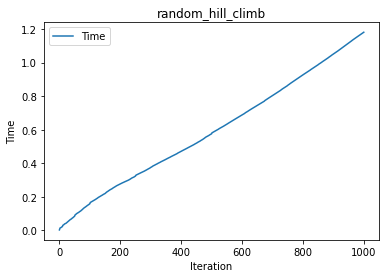

In [17]:
plt.plot(opt_curve['Iteration'],opt_curve['Time'],label='Time')
plt.xlabel('Iteration')
plt.ylabel('Time')
plt.legend()
plt.title('random_hill_climb')
plt.show()

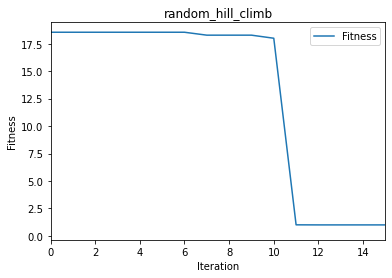

In [18]:
plt.plot(opt_curve['Iteration'],opt_curve['Fitness'],label='Fitness')
plt.xlabel('Iteration')
plt.ylabel('Fitness')
plt.xlim([0,15])
plt.legend()
plt.title('random_hill_climb')
plt.show()

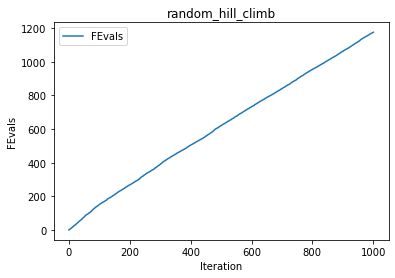

In [19]:
plt.plot(opt_curve['Iteration'],opt_curve['FEvals'],label='FEvals')
plt.xlabel('Iteration')
plt.ylabel('FEvals')
plt.legend()
plt.title('random_hill_climb')
plt.show()

### Simulated Annealing

In [20]:
grid_search_parameters = {
    'max_iters': [1000],                          # nn params
    'learning_rate': [0.001, 0.01, 0.1],                       # nn params
    'activation': [mlrose_hiive.relu, mlrose_hiive.sigmoid],            # nn params
    'restarts': [1],                             # rhc params
}

nnr = NNGSRunner(
    x_train=X_train,
    y_train=y_train,
    x_test=X_test,
    y_test=y_test,
    experiment_name='nn_sa',
    algorithm=mlrose_hiive.algorithms.sa.simulated_annealing,
    grid_search_parameters=grid_search_parameters,
    iteration_list=[1, 10, 50, 100, 250, 500, 1000],
    hidden_layer_sizes=[[1]],
    bias=True,
    early_stopping=True,
    clip_max=5,
    max_attempts=500,
    n_jobs=5,
    seed=123456,
    output_directory=None
)


run_stats_df, curves_df, cv_results_df, grid_search_cv = nnr.run()

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:   12.5s finished


In [21]:
y_test_pred = grid_search_cv.predict(X_test)
y_test_accuracy = accuracy_score(y_test, y_test_pred)
print(y_test_accuracy)

0.8771929824561403


In [22]:
y_train_pred = grid_search_cv.predict(X_train)
y_train_accuracy = accuracy_score(y_train, y_train_pred)
print(y_train_accuracy)

0.8681318681318682


In [23]:
y_test_prob=grid_search_cv.predict_proba(X_test)
show_performance_metrics(y_test_pred, y_test, y_test_prob)

Accuracy: 0.8771929824561403
Precision: 1.0
Recall: 0.8372093023255814
F1-score: 0.9113924050632911
ROC AUC Score: 0.9381613756613758


In [24]:
best_fitness = run_stats_df['Fitness'].min()
best_runs = run_stats_df[run_stats_df['Fitness'] == best_fitness]
result2=best_runs[['Fitness','FEvals','Time','activation','learning_rate']]
result2['Algorithm']='Simulated Annealing'
best_runs

,Iteration,Fitness,FEvals,Time,State,max_iters,learning_rate,restarts,init_state,algorithm,activation,bias,early_stopping,clip_max,hidden_layer_sizes,learning_rate_init,max_attempts
7,1000,0.468102,1705,2.053323,"[-2.3460603339237993, -1.266564323035994, 2.12...",1000,0.001,1,"[-0.7460603339237981, 0.933435676964006, -0.47...",sa,relu,True,True,5,[1],0.1,500


In [25]:
best_activation=best_runs['activation'].iloc[0]
best_lr=best_runs['learning_rate'].iloc[0]
best_current_start=best_runs['restarts'].iloc[0]

In [26]:
opt_curve=curves_df[(curves_df['activation']==best_activation) & (curves_df['learning_rate']==best_lr) & (curves_df['restarts']==best_current_start)]
opt_curve

,Iteration,Time,Fitness,FEvals,max_iters,learning_rate,restarts,init_state,algorithm,activation,bias,early_stopping,clip_max,hidden_layer_sizes,learning_rate_init,max_attempts
0,0,0.001867,18.544783,2.0,1000,0.001,1,"[-0.7460603339237981, 0.933435676964006, -0.47...",sa,relu,True,True,5,[1],0.1,500
1,1,0.006630,18.544783,4.0,1000,0.001,1,"[-0.7460603339237981, 0.933435676964006, -0.47...",sa,relu,True,True,5,[1],0.1,500
2,2,0.011493,18.797396,6.0,1000,0.001,1,"[-0.7460603339237981, 0.933435676964006, -0.47...",sa,relu,True,True,5,[1],0.1,500
3,3,0.012240,18.797396,7.0,1000,0.001,1,"[-0.7460603339237981, 0.933435676964006, -0.47...",sa,relu,True,True,5,[1],0.1,500
4,4,0.013850,18.797064,9.0,1000,0.001,1,"[-0.7460603339237981, 0.933435676964006, -0.47...",sa,relu,True,True,5,[1],0.1,500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,996,2.043845,0.468166,1700.0,1000,0.001,1,"[-0.7460603339237981, 0.933435676964006, -0.47...",sa,relu,True,True,5,[1],0.1,500
997,997,2.046752,0.468102,1702.0,1000,0.001,1,"[-0.7460603339237981, 0.933435676964006, -0.47...",sa,relu,True,True,5,[1],0.1,500
998,998,2.048822,0.468102,1703.0,1000,0.001,1,"[-0.7460603339237981, 0.933435676964006, -0.47...",sa,relu,True,True,5,[1],0.1,500
999,999,2.050824,0.468102,1704.0,1000,0.001,1,"[-0.7460603339237981, 0.933435676964006, -0.47...",sa,relu,True,True,5,[1],0.1,500


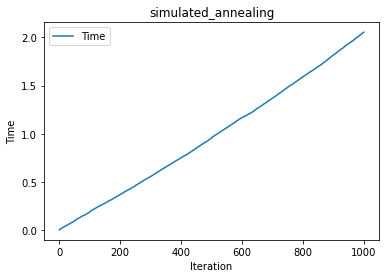

In [27]:
plt.plot(opt_curve['Iteration'],opt_curve['Time'],label='Time')
plt.xlabel('Iteration')
plt.ylabel('Time')
plt.legend()
plt.title('simulated_annealing')
plt.show()

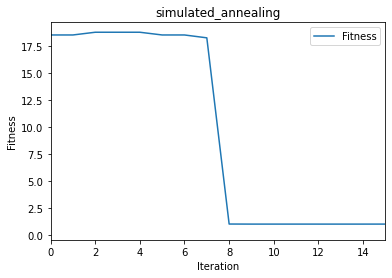

In [28]:
plt.plot(opt_curve['Iteration'],opt_curve['Fitness'],label='Fitness')
plt.xlabel('Iteration')
plt.ylabel('Fitness')
plt.xlim([0,15])
plt.legend()
plt.title('simulated_annealing')
plt.show()

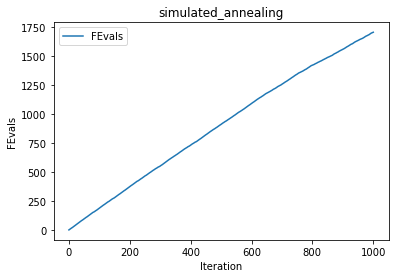

In [29]:
plt.plot(opt_curve['Iteration'],opt_curve['FEvals'],label='FEvals')
plt.xlabel('Iteration')
plt.ylabel('FEvals')
plt.legend()
plt.title('simulated_annealing')
plt.show()

### Generic Algorithm

In [30]:
grid_search_parameters = {
    'max_iters': [1000],                          # nn params
    'learning_rate': [0.001, 0.01, 0.1],                       # nn params
    'activation': [mlrose_hiive.relu, mlrose_hiive.sigmoid],            # nn params
    'restarts': [1],                             # rhc params
}

nnr = NNGSRunner(
    x_train=X_train,
    y_train=y_train,
    x_test=X_test,
    y_test=y_test,
    experiment_name='nn_ga',
    algorithm=mlrose_hiive.algorithms.ga.genetic_alg,
    grid_search_parameters=grid_search_parameters,
    iteration_list=[1, 10, 50, 100, 250, 500, 1000],
    hidden_layer_sizes=[[1]],
    bias=True,
    early_stopping=True,
    clip_max=5,
    max_attempts=500,
    n_jobs=5,
    seed=123456,
    output_directory=None
)


run_stats_df, curves_df, cv_results_df, grid_search_cv = nnr.run()

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed: 13.2min finished


In [31]:
y_test_pred = grid_search_cv.predict(X_test)
y_test_accuracy = accuracy_score(y_test, y_test_pred)
print(y_test_accuracy)

0.8859649122807017


In [32]:
y_train_pred = grid_search_cv.predict(X_train)
y_train_accuracy = accuracy_score(y_train, y_train_pred)
print(y_train_accuracy)

0.8747252747252747


In [33]:
y_test_prob=grid_search_cv.predict_proba(X_test)
show_performance_metrics(y_test_pred, y_test, y_test_prob)

Accuracy: 0.8859649122807017
Precision: 0.9583333333333334
Recall: 0.8734177215189873
F1-score: 0.913907284768212
ROC AUC Score: 0.9408068783068784


In [34]:
best_fitness = run_stats_df['Fitness'].min()
best_runs = run_stats_df[run_stats_df['Fitness'] == best_fitness]
result3=best_runs[['Fitness','FEvals','Time','activation','learning_rate']]
result3['Algorithm']='Generic Algorithm'
best_runs

,Iteration,Fitness,FEvals,Time,State,max_iters,learning_rate,restarts,init_state,algorithm,activation,bias,early_stopping,clip_max,hidden_layer_sizes,learning_rate_init,max_attempts
7,1000,0.452513,201279,114.867163,"[4.99981117874059, -4.512517848411523, 4.71232...",1000,0.001,1,"[-0.7460603339237981, 0.933435676964006, -0.47...",ga,sigmoid,True,True,5,[1],0.1,500


In [35]:
best_activation=best_runs['activation'].iloc[0]
best_lr=best_runs['learning_rate'].iloc[0]
best_current_start=best_runs['restarts'].iloc[0]

In [36]:
opt_curve=curves_df[(curves_df['activation']==best_activation) & (curves_df['learning_rate']==best_lr) & (curves_df['restarts']==best_current_start)]
opt_curve

,Iteration,Time,Fitness,FEvals,max_iters,learning_rate,restarts,init_state,algorithm,activation,bias,early_stopping,clip_max,hidden_layer_sizes,learning_rate_init,max_attempts
0,0,0.114991,0.600667,201.0,1000,0.001,1,"[-0.7460603339237981, 0.933435676964006, -0.47...",ga,sigmoid,True,True,5,[1],0.1,500
1,1,0.243898,0.600667,403.0,1000,0.001,1,"[-0.7460603339237981, 0.933435676964006, -0.47...",ga,sigmoid,True,True,5,[1],0.1,500
2,2,0.375863,0.600667,604.0,1000,0.001,1,"[-0.7460603339237981, 0.933435676964006, -0.47...",ga,sigmoid,True,True,5,[1],0.1,500
3,3,0.493373,0.570030,806.0,1000,0.001,1,"[-0.7460603339237981, 0.933435676964006, -0.47...",ga,sigmoid,True,True,5,[1],0.1,500
4,4,0.609599,0.570030,1007.0,1000,0.001,1,"[-0.7460603339237981, 0.933435676964006, -0.47...",ga,sigmoid,True,True,5,[1],0.1,500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,996,114.408121,0.452513,200475.0,1000,0.001,1,"[-0.7460603339237981, 0.933435676964006, -0.47...",ga,sigmoid,True,True,5,[1],0.1,500
997,997,114.523631,0.452513,200676.0,1000,0.001,1,"[-0.7460603339237981, 0.933435676964006, -0.47...",ga,sigmoid,True,True,5,[1],0.1,500
998,998,114.637477,0.452513,200877.0,1000,0.001,1,"[-0.7460603339237981, 0.933435676964006, -0.47...",ga,sigmoid,True,True,5,[1],0.1,500
999,999,114.752822,0.452513,201078.0,1000,0.001,1,"[-0.7460603339237981, 0.933435676964006, -0.47...",ga,sigmoid,True,True,5,[1],0.1,500


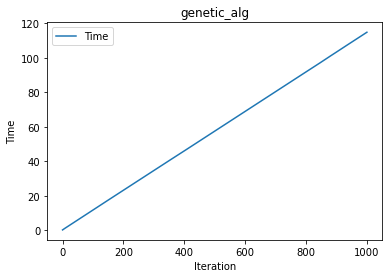

In [37]:
plt.plot(opt_curve['Iteration'],opt_curve['Time'],label='Time')
plt.xlabel('Iteration')
plt.ylabel('Time')
plt.legend()
plt.title('genetic_alg')
plt.show()

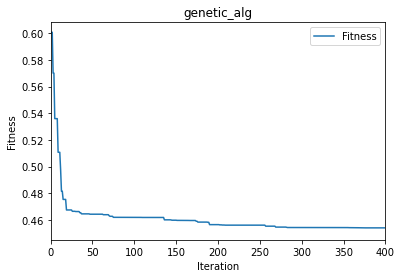

In [46]:
plt.plot(opt_curve['Iteration'],opt_curve['Fitness'],label='Fitness')
plt.xlabel('Iteration')
plt.ylabel('Fitness')
plt.xlim([0,400])
plt.legend()
plt.title('genetic_alg')
plt.show()

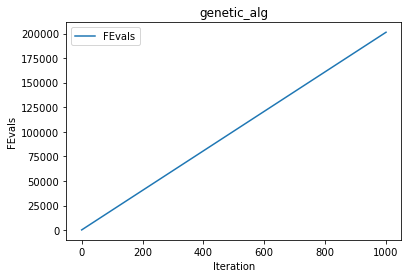

In [39]:
plt.plot(opt_curve['Iteration'],opt_curve['FEvals'],label='FEvals')
plt.xlabel('Iteration')
plt.ylabel('FEvals')
plt.legend()
plt.title('genetic_alg')
plt.show()

### Gradient Descent

In [47]:
grid_search_parameters = {
    'max_iters': [1000],                          # nn params
    'learning_rate': [0.001, 0.01, 0.1],                       # nn params
    'activation': [mlrose_hiive.relu, mlrose_hiive.sigmoid],            # nn params
    'restarts': [1],                             # rhc params
}

nnr_benchmark = NNGSRunner(
    x_train=X_train,
    y_train=y_train,
    x_test=X_test,
    y_test=y_test,
    experiment_name='nn_ga',
    algorithm=mlrose_hiive.algorithms.gd.gradient_descent,
    grid_search_parameters=grid_search_parameters,
    iteration_list=[1, 10, 50, 100, 250, 500, 1000],
    hidden_layer_sizes=[[1]],
    bias=True,
    early_stopping=True,
    clip_max=5,
    max_attempts=500,
    n_jobs=5,
    seed=123456,
    output_directory=None
)


run_stats_df, curves_df, cv_results_df, grid_search_cv = nnr_benchmark.run()

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    6.3s finished


In [48]:
y_test_pred = grid_search_cv.predict(X_test)
y_test_accuracy = accuracy_score(y_test, y_test_pred)
print(y_test_accuracy)

0.3684210526315789


In [49]:
y_train_pred = grid_search_cv.predict(X_train)
y_train_accuracy = accuracy_score(y_train, y_train_pred)
print(y_train_accuracy)

0.37362637362637363


In [50]:
y_test_prob=grid_search_cv.predict_proba(X_test)
show_performance_metrics(y_test_pred, y_test, y_test_prob)

Accuracy: 0.3684210526315789
Precision: 0.0
Recall: 0.0
F1-score: 0.0
ROC AUC Score: 0.5


In [79]:
best_fitness = run_stats_df['Fitness'].min()
best_runs = run_stats_df[run_stats_df['Fitness'] == best_fitness]
result4=best_runs[['Fitness','FEvals','Time','activation','learning_rate']]
result4['Algorithm']='Gradient Descent'
best_runs

,Iteration,Fitness,FEvals,Time,State,max_iters,learning_rate,restarts,init_state,algorithm,activation,bias,early_stopping,clip_max,hidden_layer_sizes,learning_rate_init,max_attempts
2,10,0.693147,None,0.018369,"[-5.0, -5.0, -5.0, -5.0, -0.5014723627269508, ...",1000,0.001,1,"[-0.7460603339237981, 0.933435676964006, -0.47...",gd,relu,True,True,5,[1],0.1,500
3,50,0.693147,None,0.066498,"[-5.0, -5.0, -5.0, -5.0, -0.5014723627269508, ...",1000,0.001,1,"[-0.7460603339237981, 0.933435676964006, -0.47...",gd,relu,True,True,5,[1],0.1,500
4,100,0.693147,None,0.127153,"[-5.0, -5.0, -5.0, -5.0, -0.5014723627269508, ...",1000,0.001,1,"[-0.7460603339237981, 0.933435676964006, -0.47...",gd,relu,True,True,5,[1],0.1,500
5,250,0.693147,None,0.336339,"[-5.0, -5.0, -5.0, -5.0, -0.5014723627269508, ...",1000,0.001,1,"[-0.7460603339237981, 0.933435676964006, -0.47...",gd,relu,True,True,5,[1],0.1,500
6,500,0.693147,None,0.679021,"[-5.0, -5.0, -5.0, -5.0, -0.5014723627269508, ...",1000,0.001,1,"[-0.7460603339237981, 0.933435676964006, -0.47...",gd,relu,True,True,5,[1],0.1,500
7,1000,0.693147,None,0.684107,"[-5.0, -5.0, -5.0, -5.0, -0.5014723627269508, ...",1000,0.001,1,"[-0.7460603339237981, 0.933435676964006, -0.47...",gd,relu,True,True,5,[1],0.1,500


In [61]:
best_activation=best_runs['activation'].iloc[0]
best_lr=best_runs['learning_rate'].iloc[0]
best_current_start=best_runs['restarts'].iloc[0]

In [62]:
opt_curve=curves_df[(curves_df['activation']==best_activation) & (curves_df['learning_rate']==best_lr) & (curves_df['restarts']==best_current_start)]
opt_curve

,Iteration,Time,Fitness,FEvals,max_iters,learning_rate,restarts,init_state,algorithm,activation,bias,early_stopping,clip_max,hidden_layer_sizes,learning_rate_init,max_attempts
0,0,0.002080,18.610375,NaN,1000,0.001,1,"[-0.7460603339237981, 0.933435676964006, -0.47...",gd,relu,True,True,5,[1],0.1,500
1,1,0.005819,18.610375,3.0,1000,0.001,1,"[-0.7460603339237981, 0.933435676964006, -0.47...",gd,relu,True,True,5,[1],0.1,500
2,2,0.009301,0.693147,5.0,1000,0.001,1,"[-0.7460603339237981, 0.933435676964006, -0.47...",gd,relu,True,True,5,[1],0.1,500
3,3,0.010421,0.693147,7.0,1000,0.001,1,"[-0.7460603339237981, 0.933435676964006, -0.47...",gd,relu,True,True,5,[1],0.1,500
4,4,0.011541,0.693147,9.0,1000,0.001,1,"[-0.7460603339237981, 0.933435676964006, -0.47...",gd,relu,True,True,5,[1],0.1,500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,497,0.674528,0.693147,995.0,1000,0.001,1,"[-0.7460603339237981, 0.933435676964006, -0.47...",gd,relu,True,True,5,[1],0.1,500
498,498,0.676169,0.693147,997.0,1000,0.001,1,"[-0.7460603339237981, 0.933435676964006, -0.47...",gd,relu,True,True,5,[1],0.1,500
499,499,0.677593,0.693147,999.0,1000,0.001,1,"[-0.7460603339237981, 0.933435676964006, -0.47...",gd,relu,True,True,5,[1],0.1,500
500,500,0.679021,0.693147,1001.0,1000,0.001,1,"[-0.7460603339237981, 0.933435676964006, -0.47...",gd,relu,True,True,5,[1],0.1,500


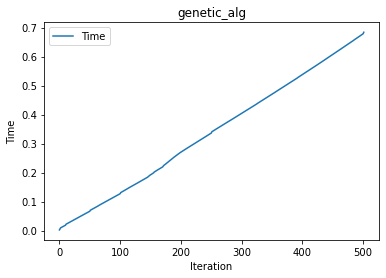

In [63]:
plt.plot(opt_curve['Iteration'],opt_curve['Time'],label='Time')
plt.xlabel('Iteration')
plt.ylabel('Time')
plt.legend()
plt.title('genetic_alg')
plt.show()

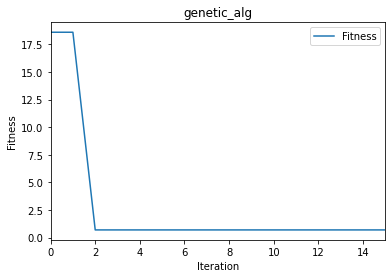

In [64]:
plt.plot(opt_curve['Iteration'],opt_curve['Fitness'],label='Fitness')
plt.xlabel('Iteration')
plt.ylabel('Fitness')
plt.xlim([0,15])
plt.legend()
plt.title('genetic_alg')
plt.show()

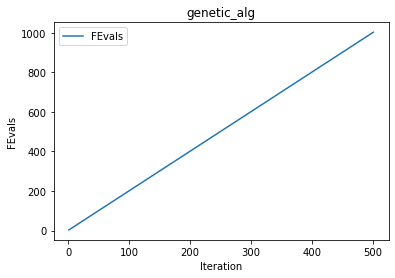

In [65]:
plt.plot(opt_curve['Iteration'],opt_curve['FEvals'],label='FEvals')
plt.xlabel('Iteration')
plt.ylabel('FEvals')
plt.legend()
plt.title('genetic_alg')
plt.show()

### Algorithm Comparison

In [83]:
results=pd.concat([result1,result2,result3])

In [84]:
results

,Fitness,FEvals,Time,activation,learning_rate,Algorithm
7,0.542501,1176,1.181279,relu,0.001,Randomized Hill Climbing
7,0.468102,1705,2.053323,relu,0.001,Simulated Annealing
7,0.452513,201279,114.867163,sigmoid,0.001,Generic Algorithm
